# Проект QA

## Yes/No Questions

Данные: BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Вопросы собирались из анонимных запросов в Google, если была возвращена ссылка на Википедию. Затем вопрос-статья передаются человеку для аннотации. Аннотатор находит отрывок в статья, отвечающий на вопрос. Возвращаются вопрос, отрывок, ответ.
https://arxiv.org/pdf/1905.10044.pdf

Русскоязычный корпус (train-dev split) доступен:  https://russiansuperglue.com/tasks/task_info/DaNetQA

Для обучения использовалась train часть корпуса, для валидации и тестирования – dev часть. 

In [ ]:
import os
import re
import nltk
import string
import numpy as np
import pandas as pd
import gensim

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install transformers
!pip install catalyst

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

from tqdm import tqdm_notebook

import transformers
from transformers import BertModel, BertTokenizerFast, BertConfig

from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, SchedulerCallback, F1ScoreCallback
from catalyst.utils import set_global_seed, prepare_cudnn

In [ ]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [ ]:
train_data = pd.read_json("/content/train.jsonl", lines=True, orient='records')
dev_data = pd.read_json("/content/dev.jsonl", lines=True, orient="records")

In [ ]:
train_data.head()

,question,title,answer,passage
0,do iran and afghanistan speak the same language,Persian language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,Good Samaritan law,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,Windows Movie Maker,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,Powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online,False,As with other games in The Elder Scrolls serie...


## Load and analysis data

### Эксплоративный анализ

In [ ]:
print('frequency train data', train_data.answer.mean())
print('frequency dev data', dev_data.answer.mean())

frequency train data 0.6231038506417736
frequency dev data 0.6217125382262997


In [ ]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print("Train question mean long:", train_data.question.apply(lambda x: len(word_tokenize(x))).mean())
print("Train question max long:", train_data.question.apply(lambda x: len(word_tokenize(x))).max())
print("Train question min long:", train_data.question.apply(lambda x: len(word_tokenize(x))).min())

Train question mean long: 8.859234114776704
Train question max long: 21
Train question min long: 4


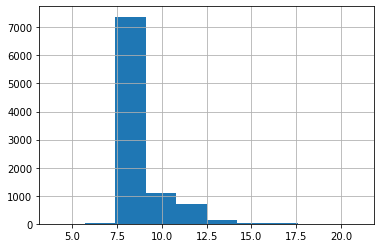

In [ ]:
train_data.question.apply(lambda x: len(word_tokenize(x))).hist()

In [ ]:
print("Test question mean long:", dev_data.question.apply(lambda x: len(word_tokenize(x))).mean())
print("Test question max long:", dev_data.question.apply(lambda x: len(word_tokenize(x))).max())
print("Test question min long:", dev_data.question.apply(lambda x: len(word_tokenize(x))).min())

Test question mean long: 8.744954128440368
Test question max long: 17
Test question min long: 3


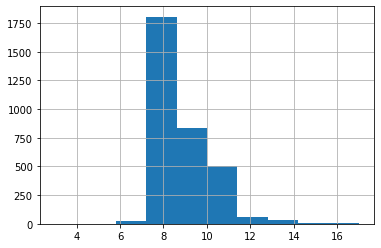

In [ ]:
dev_data.question.apply(lambda x: len(word_tokenize(x))).hist()

In [ ]:
dev_data.head()

,question,title,answer,passage
0,does ethanol take more energy make that produces,Ethanol fuel,False,All biomass goes through at least some of thes...
1,is house tax and property tax are same,Property tax,True,Property tax or 'house tax' is a local tax on ...
2,is pain experienced in a missing body part or ...,Phantom pain,True,Phantom pain sensations are described as perce...
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts,True,Harry Potter and the Escape from Gringotts is ...
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine,True,Hydroxyzine preparations require a doctor's pr...


In [ ]:
print("Train passage mean long:", train_data.passage.apply(lambda x: len(word_tokenize(x))).mean())
print("Train passage max long:", train_data.passage.apply(lambda x: len(word_tokenize(x))).max())
print("Train passage min long:", train_data.passage.apply(lambda x: len(word_tokenize(x))).min())

Train passage mean long: 107.8385488490506
Train passage max long: 848
Train passage min long: 8


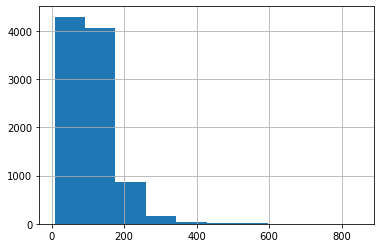

In [ ]:
train_data.passage.apply(lambda x: len(word_tokenize(x))).hist()

In [ ]:
test = train_data.passage.apply(lambda x: len(word_tokenize(x)))

In [ ]:
print("Test passage mean long:", dev_data.passage.apply(lambda x: len(word_tokenize(x))).mean())
print("Test passage max long:", dev_data.passage.apply(lambda x: len(word_tokenize(x))).max())
print("Test passage min long:", dev_data.passage.apply(lambda x: len(word_tokenize(x))).min())

Test passage mean long: 106.77033639143731
Test passage max long: 969
Test passage min long: 9


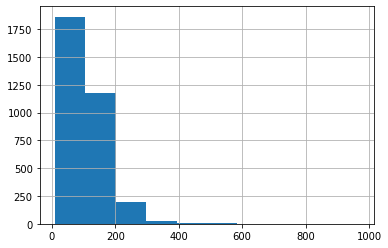

In [ ]:
dev_data.passage.apply(lambda x: len(word_tokenize(x))).hist()

#### Первое слово в вопросе

In [ ]:
train_data['first_word'] = train_data.question.apply(lambda x : word_tokenize(x)[0])

In [ ]:
dev_data['first_word'] = dev_data.question.apply(lambda x : word_tokenize(x)[0])

In [ ]:
train_data.first_word.value_counts().head(20)

is       4191
can      1136
does      952
are       693
do        664
did       462
was       335
has       302
will      181
the        91
have       70
in         35
were       25
if         17
a          16
what       11
when       10
could       9
who         5
where       5
Name: first_word, dtype: int64

In [ ]:
dev_data.first_word.value_counts().head(20)

is       1532
can       394
does      373
are       251
do        243
did       135
has       124
was       104
will       68
have       25
were       17
would       2
could       2
Name: first_word, dtype: int64

In [ ]:
train_data.groupby('first_word').agg(['mean', 'count']).sort_values([('answer', 'count')], ascending=False).head(20)

answer      
                mean count
first_word                
is          0.594130  4191
can         0.725352  1136
does        0.590336   952
are         0.600289   693
do          0.552711   664
did         0.668831   462
was         0.644776   335
has         0.771523   302
will        0.563536   181
the         0.703297    91
have        0.671429    70
in          0.742857    35
were        0.560000    25
if          0.588235    17
a           0.750000    16
what        0.636364    11
when        0.700000    10
could       0.333333     9
where       0.800000     5
who         0.800000     5

In [ ]:
dev_data.groupby('first_word').agg(['mean', 'count']).sort_values([('answer', 'count')], ascending=False).head(20)

answer      
                mean count
first_word                
is          0.592037  1532
can         0.718274   394
does        0.638070   373
are         0.573705   251
do          0.551440   243
did         0.644444   135
has         0.798387   124
was         0.625000   104
will        0.632353    68
have        0.760000    25
were        0.647059    17
could       0.500000     2
would       1.000000     2

## Baseline


Оцените accuracy совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части

In [ ]:
y = dev_data.answer.to_list()
y_pred = [True] * len(y)
accuracy_score(y, y_pred)

0.6217125382262997

Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

In [ ]:
fasttext_train = '__label__' + train_data['answer'].astype(int).astype(str) + ' ' + train_data['question'] + ' ' + train_data['passage']
fasttext_dev = '__label__' + dev_data['answer'].astype(int).astype(str) + ' ' + dev_data['question'] + ' ' + dev_data['passage']

In [ ]:
np.savetxt('fasttext_train.train', fasttext_train.values, fmt='%s')
np.savetxt('fasttext_dev.dev', fasttext_dev.values, fmt='%s')

In [ ]:
model = fasttext.train_supervised(input='fasttext_train.train')
model.test('fasttext_dev.dev')[1]

0.6428134556574924

## Embedding sequence

Кластеризовать вопросы. Присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части

In [ ]:
train_question = train_data[['question', 'answer']]
dev_question = dev_data[['question', 'answer']]

Векторное представление вопросов

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("gdrive/My Drive/МФТИ/NLP/Homework3")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format(fname='GoogleNews-vectors-negative300.bin.gz', limit=500000, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function

/usr/local/lib/python3.6/dist-packages/gensim/models/utils_any2vec.py:212: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:1438: ResourceWarning:

unclosed file <_io.BufferedReader name='GoogleNews-vectors-negative300.bin.gz'>



In [ ]:
stopWords = set(stopwords.words('english'))

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning:

unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>



In [ ]:
def question_to_vec(question, embeddings, dim=300):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """

    # удаление пунктуации
    words = [token.lower() for token in tokenizer.tokenize(question) if token not in string.punctuation]
    n_known = 0
    result = np.array([0] * dim, dtype='float16')
    
    for word in words:
        if word in embeddings:           
            result += embeddings.wv[word]
            n_known += 1
     
    if n_known != 0:
        return result/n_known
    else:
        return result
  
def text_prepare(text):

    # Перевести символы в нижний регистр
    text = text.lower()
    
    # Заменить символы пунктуации на пробелы
    #text = re.sub(r'[{}]'.format(string.punctuation), ' ', text)
    
    # Удалить "плохие" символы
    #text = re.sub('[^A-Za-z ]', '', text)
    
    #удалить значения в скобках
    text = re.sub(r'\([^\)]+\)*', '', text)
    # Удалить стопслова.
    #stopWords = set(stopwords.words('english'))
    #text = ' '.join([token for token in tokenizer.tokenize(text) if token not in stopWords])
    return text

### Vizualization embeddings

In [ ]:
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/
!echo $LD_LIBRARY_PATH
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

In [ ]:
from tsnecuda import TSNE as TSNE_CUDA
from sklearn.preprocessing import StandardScaler
from bokeh.io import output_notebook #библиотека, которая позволяет визуализировать данные в веб

In [ ]:
import tsnecuda
tsnecuda.test()

In [ ]:
def get_tsne_cuda_emb(df, wv_embeddings):  

  df['question_clear'] = df['question'].apply(text_prepare)
  df = df.drop_duplicates('question_clear')

  df['vec'] = [question_to_vec(question, wv_embeddings) for question in df.question_clear.to_list()]

  return df

In [ ]:
df = get_tsne_cuda_emb(train_question, wv_embeddings)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_vec = np.vstack(df.vec.to_numpy())

In [ ]:
tsne_cuda = TSNE_CUDA(
    n_components=2,
)

In [ ]:
embeddings_gpu = tsne_cuda.fit_transform(df_vec)
ss = StandardScaler().fit(embeddings_gpu)
word_vectors_tsne = ss.transform(embeddings_gpu)

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
output_notebook()

def draw_vectors(x, y, radius=2, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], token=df.question)

Figure(id='1002', ...)

### Bert Embedding

1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

In [ ]:
train_data['passage_prepare'] = train_data.passage.apply(text_prepare)
dev_data['passage_prepare'] = dev_data.passage.apply(text_prepare)

#test_data, valid_data = train_test_split(dev_data, train_size=0.9, stratify=dev_data['answer'])


In [ ]:
class TextClassificationDataSet(TensorDataset):

  def __init__(self, data, tokenizer, max_seq_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_seq_len = max_seq_len

    encoded = [tokenizer.encode_plus(d['question'], d['passage_prepare'],
                                              add_special_tokens=True, 
                                              return_token_type_ids=False,
                                              max_length=self.max_seq_len,                                            
                                              truncation='only_second',
                                              padding='max_length',
                                              return_tensors='pt') for index, d in data.iterrows()]


    self.input_ids, self.attention_mask =  \
                          zip(*[(e.input_ids, e.attention_mask) for e in encoded])

    #self.p_input_ids, self.p_attention_mask =  \
    #                      zip(*[(e.input_ids, e.attention_mask) for e in passage_encoded])

    self.targets = data['answer']

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return {
        'input_ids': self.input_ids[idx],
        'attention_mask': self.attention_mask[idx],
        #'p_input_ids': self.p_input_ids[idx],
        #'p_attention_mask': self.p_attention_mask[idx],
        'target': self.targets[idx]
    }



In [ ]:
class BertEmb(nn.Module):
  def __init__(self, pretrained_model_name, config):
    super().__init__()
    self.emb = BertModel.from_pretrained(pretrained_model_name, config=config)
    
    for p in self.emb.parameters():
      p.requires_grad = False

  def forward(self, input_ids, attention_mask):
    output = self.emb(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask)
    return output[1]

In [ ]:
class BinaryClassification(nn.Module):
  def __init__(self, embeddings, hidden_size, dropout):
    super().__init__()

    self.emb = embeddings
    self.classifier = nn.Linear(hidden_size, 1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input_ids, attention_mask):
    emb = self.emb(input_ids,
                   attention_mask)

    emb = self.dropout(emb)
    logits = self.classifier(emb)

    return logits

In [ ]:
for n, p in model.named_parameters():
  print(p.requires_grad)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


MODEL_NAME = 'bert-base-uncased'
#MODEL_NAME = 'google/bert_uncased_L-2_H-128_A-2'
config = BertConfig.from_pretrained(MODEL_NAME)
BATCH_SIZE = 32
MAX_SEQ_LEN = max(512, config.max_position_embeddings)

tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [ ]:
embeddings = BertEmb(MODEL_NAME, config)
model = BinaryClassification(embeddings, config.hidden_size, config.hidden_dropout_prob)
model = model.to(device)

In [ ]:
def get_dataloader(data, tokenizer, max_seq_len, batch_size):
  dataset = TextClassificationDataSet(data, tokenizer, max_seq_len)

  #targets = data['answer']
  #dataset = TensorDataset(input_ids, attention_mask, torch.tensor(targets))
  data_sampler = RandomSampler(dataset)
  dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
  return dataloader

train_dataloader = get_dataloader(train_data, tokenizer, MAX_SEQ_LEN, BATCH_SIZE)
dev_dataloader = get_dataloader(dev_data, tokenizer, MAX_SEQ_LEN, BATCH_SIZE)
#valid_dataloader = get_dataloader(valid_data, tokenizer, MAX_SEQ_LEN, BATCH_SIZE)

dataloaders = {
    "train": train_dataloader,
    "test": dev_dataloader
}

In [ ]:
L_R = 3e-5
EPOCHS = 3
WARMUP_STEPS = 100
T_TOTAL = len(train_dataloader) * EPOCHS

OPTIMIZER_GROUPED_PARAMETERS = [
      {'params': [p for n, p in model.named_parameters()], "weight_decay": 0.1}
]

CRITERION = torch.nn.BCEWithLogitsLoss()
OPTIMIZER = transformers.AdamW(OPTIMIZER_GROUPED_PARAMETERS, lr=L_R)
SCHEDULER = transformers.get_linear_schedule_with_warmup(
    OPTIMIZER, num_warmup_steps=WARMUP_STEPS, num_training_steps=T_TOTAL
)

LOG_DIR = 'logs/'

In [ ]:
T_TOTAL

885

In [ ]:
from tqdm.notebook import tqdm
grad_acc_steps = 1
train_loss_values = []
for _ in tqdm(range(EPOCHS), desc="Epoch"):

  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):
      input_ids = batch['input_ids'].to(device)
      attention_masks = batch['attention_mask'].to(device)

      #p_input_ids = batch['p_input_ids'].to(device)
      #p_attention_masks = batch['p_attention_mask'].to(device)

      labels = batch['target'].float().to(device)    

      OPTIMIZER.zero_grad()
      outputs = model(input_ids.transpose(1,2).squeeze(2), attention_masks.transpose(1,2).squeeze(2))

      loss = CRITERION(outputs, labels.unsqueeze(1))
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        OPTIMIZER.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  print(epoch_train_loss)


0.68496303336095
0.6857993976544525
0.6850405442512641



In [ ]:
epoch_train_loss

0.6909115312463147

In [ ]:
runner = SupervisedRunner(
    input_key=(
        "input_ids",
        "attention_mask",
        "token_type_ids"
    )
)

runner.train(
    model = model,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    scheduler=SCHEDULER,
    loaders=dataloaders,
    callbacks=[
               AccuracyCallback(num_classes=2),
               SchedulerCallback(mode='batch'),
    ],
    logdir=LOG_DIR,
    load_best_on_end=True,
    num_epochs=EPOCHS,
)

### DrQA

In [ ]:
pip install torchtext

#from fasttext import load_model
from torchtext.vocab import FastText
embedding = FastText('en')

!pip install fasttext

import fasttext
import torch
import numpy as np

ft = fasttext.load_model("cc.en.300.bin")
word_vectors = torch.from_numpy(ft.get_input_matrix())
classifier_fc = torch.from_numpy(ft.get_output_matrix())

ft.get_subwords("something")
something_word_pytorch = torch.mean(word_vectors[ft.get_subwords("something")[1]], dim=0)
something_word_ft = ft["something"]

In [ ]:
class DocumentReader(nn.Module):

    def __init__(self, embedding, paragraph_encoding, question_encoding):
      self.embedding = embedding 
      self.paragraph_encoding = paragraph_encoding
      self.question_encoding = question_encoding    
    
    def forward(self, batch):
      paragraph = batch.context_word.transpose(0, 1).to(device)
      question = batch.question_word.transpose(0 ,1).to(device)

      par_emb = self.embedding(paragraph)
      quest_emb = self.embedding(question)

      self.paragraph_encoding(par_emb, quest_emb, paragraph)

      self.question_encoding()


In [ ]:
class ParagraphEncoding(nn.Module):

    def __init__(self, emb_dim, hidden_dim, dropout):
      self.lstm = nn.LSTM(input_size=emb_dim, 
                          hidden_size=hidden_dim, 
                          bidirectional=True,
                          batch_size=True,
                          dropout=0.1)
      
      self.dropout = nn.Dropout()

    def get_ner_tags(self):
      pass

    def get_pos_tag(self, word_ind):
      

    def get_pos_tags(self):
      pass

    def get_aligned_question_emb(self, par_emb, quest_emb):
      pass

    def forward(self, par_emb, quest_emb, paragraph):
      embedding = self.embedding(tokens)

In [ ]:
class QuestionEncoding(nn.Module):

  def __init__(self, emb_dim, hidden_dim):
    self.lstm = nn.LSTM(input_size=emm_dim,
                        hidden_size=hidden_dim, 
                        bidirectional=True, 
                        batch_first=True,
                        dropout=0.1)
    

#### Embeddings

In [ ]:
class FasttextEmbedding():

  def __init__(self, filepath):
      self.model = load_model(filepath)
  
  def get_word_vector(self, word):
     return self.model.get_word_vector(word)

  def get_word_vectors(self, words):
      vectors = []
      for word in words:
        vectors.apped(self.get_word_vector(word))
      return np.array(vectors)


In [ ]:
class Word2VecEmbedding(nn.Module):

    def __init__(self, embedding_wights, dropout=0.2):
      self.embedding = nn.Embedding.from_pretrained(embedding_weights)
      self.dropout = nn.Dropout(dropout)
    
    def forward(self, tokens):
      return self.dropout(self.embedding(tokens))


In [ ]:
embedding_weights = torch.FloatTensor(wv_embeddings.vectors)  

#### Spacy

In [ ]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

In [ ]:
tokens = nlp.tokenizer('But Google This is a sentence.')

In [ ]:
text = 'But Google This is a sentence.'

In [ ]:
nlp.tagger(tokens)
nlp.entity(tokens)

But Google This is a sentence.

In [ ]:
data = []
for i in range(len(tokens)):
  # Get whitespace
  start_ws = tokens[i].idx
  if i + 1 < len(tokens):
    end_ws = tokens[i + 1].idx
  else:
    end_ws = tokens[i].idx + len(tokens[i].text)

  data.append((
                tokens[i].text,
                tokens[i].tag_,
                tokens[i].lemma_,
                tokens[i].ent_type_,
            ))

In [ ]:
data

[('But', 'CC', 'but', ''),
 ('Google', 'NNP', 'Google', 'ORG'),
 ('This', 'DT', 'this', ''),
 ('is', 'VBZ', 'be', ''),
 ('a', 'DT', 'a', ''),
 ('sentence', 'NN', 'sentence', ''),
 ('.', '.', '.', '')]

In [ ]:
doc = nlp("But Google This is a sentence.")
print([(w.text, w.pos_) for w in doc])

In [ ]:
for ent in doc.ents:
  print(ent.text, ent.start_char, ent.end_char, ent.label_)

Google 4 10 ORG


In [ ]:
from torchtext.vocab import GloVe, FastText
from torchtext.data import Field, Dataset, NestedField, BucketIterator

In [ ]:
class PrepareData():

  def __init__(self, train_df, dev_df, vectors):

    self.vectors = vectors

    char_nesting_field = Field(batch_first=True, tokenize=list, lower=True)
    char_field = NestedField(char_nesting_field, init_token="<sos>", eos_token="<eos>", tokenize="spacy")
    word_field= Field(init_token="<sos>", eos_token="<eos>", lower=True, tokenize="spacy")
    label_field = Field(sequential=False, is_targe=True, use_vocab=False)

    self.fields = [("question_char", char_field), ("question_word", word_field),
                   ("context_char", char_field), ("context_word", word_field),
                   ("answer", label_field)]

    self.field_lst = [("question", (char_field, word_field)),
                      ("context", (char_field, word_field)),
                      ("answer", label_field)]

    self.train_dataset = self.get_dataset(train_df)
    self.test_dataset = self.get_dataset(test_df)

    char.build_vocab(self.train_dataset)
    word.build_vocab(self.train_dataset, vectors=self.vectors)

    self.char_vocab = char.vocab
    self.word_vocab = word.vocab

    pos_tags = []
    ner_tags = []

    ind2pos_tags = []
    ind2ner_tags = []

    for data in tqdm(train_dataset):
      doc = nlp(' '.join(data.question_word) + ' ' + ' '.join(data.context_word))

      pos_tags.extend([token.pos_ for token in doc])
      ner_tags.extend([token.label_ for token in doc.ents])

      ind2pos_tags.extend([(self.word_vocab.stoi[str(token)], token.pos_) for token in doc])
      ind2ner_tags.extend([(self.word_vocab.stoi[str(token)], token.label_) for token in doc.ents])

      self.pos_tag_voc = {tag: i for i, tag in enumerate(set(pos_tags))}
      self.ner_voc = {tag: i+1 for i, tag in enumerate(set(ner_tags))}
      self.ner_voc['None'] = 0

      self.ind2pos_tags = {tag[0] : self.pos_tag_voc[tag[1]] for tag in ind2pos_tags}
      self.ind2ner = {tag[0] : self.ner_voc[tag[1]] for tag in ind2ner_tags}


  def get_dataset(self, df):

    example = [(d.question, d.title + '. ' + d.passage, d.answer) for d in df.iterrows())]
    return Dataset([Example.fromlist(example, self.field_lst) for example in examples], self.fields)
  

In [ ]:
vectors = FastText(language='en', max_vectors=30000)

In [ ]:
prepare_data = PrepareData(train_df, test_df, vectors)

In [ ]:
import torch
from collections import Counter

class ReaderDataset(Dataset):

  def __init__(self, examples, model):
    self.model = model
    self.example = example

  def __len__(self):
    return len(self.example)

  def __getitem__(self, index):
    return self._vectorize(self.example[index], self.model)

  def lengths(self):
    return [(len(ex['document']), len(ex['question']))
                for ex in self.example]

  def _vectorize(self, example, model):

    word_dict = model.word_dict
    feature_dict = model.feature_dict

    #index words
    document = torch.LongTensor([word_dict[w] for w in ex['document']])
    question = torch.LongTensor([word_dict[w] for w in ex['question']])

    features = torch.zeros(len(ex['document']), len(feature_dict))

    #exact_match
    q_words_cased = {w for w in ex['question']}
    q_words_uncased = {w.lower() for w in ex['question']}
    q_lemma = {w for w in ex['qlemma']}

    for i in range(len(ex['document'])):
      if ex['document'][i] in q_words_cased:
        features[i][feature_dict['in_question']] = 1.0
      
      if ex['document'][i].lower() in q_words_uncased:
        features[i][feature_dict['in_question_uncased']] = 1.0

      if q_lemma and ex['lemma'][i] in q_lemma:
        features[i][feature_dict['in_question_lemma']] = 1.0

      
    #pos
    for i, w in enumerate(ex['pos']):
      f = 'pos=%s' % w
      if f in feature_dict:
        features[i][feature_dict[f]] = 1.0

    
    #ner
    for i, w in enumerate(ex['ner']):
      f = 'ner=%s' % w
      if f in feature_dict:
        features[i][feature_dict[f]] = 1.0

    #tf
    counter = Counter([w.lower() for w in ex['document']])
    l = len(ex['document'])
    for i, w in enumerate(ex['document']):
      features[i][feature_dict['tf']] = counter[w.lower()] * 1.0 / 1


    if 'answer' not in ex:
      return document, features, question

    return document, features, question, answer


# Вывод

In [1]:
import pandas as pd

In [3]:
pd.DataFrame([['Baseline', 0.62], ['Bert', 0.68]], columns=['method', 'accuracy']).set_index('method')

,accuracy
method,
Baseline,0.62
Bert,0.68
